# SEE FOOD

In [65]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Activation
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras import Sequential

In [2]:
!nvidia-smi -L

GPU 0: GeForce MX230 (UUID: GPU-ba3b3f04-4bc8-7fef-cec0-4ab6f04f0734)


## Helper Function

In [3]:
from helper_functions import create_tensorboard_callback, plot_loss_curves, pred_and_plot, unzip_data, walk_through_dir, compare_historys, make_confusion_matrix

# Using Dataset

* **We are using food101 dataset of tensorflow**
* This dataset consists of 101 food categories, with 101'000 images. For each class, 250 manually reviewed test images are provided as well as 750 training images

In [5]:
walk_through_dir('data/all_food_classes')

There are 2 directories and 0 images in 'data/all_food_classes'.
There are 101 directories and 0 images in 'data/all_food_classes\test'.
There are 0 directories and 250 images in 'data/all_food_classes\test\apple_pie'.
There are 0 directories and 250 images in 'data/all_food_classes\test\baby_back_ribs'.
There are 0 directories and 250 images in 'data/all_food_classes\test\baklava'.
There are 0 directories and 250 images in 'data/all_food_classes\test\beef_carpaccio'.
There are 0 directories and 250 images in 'data/all_food_classes\test\beef_tartare'.
There are 0 directories and 250 images in 'data/all_food_classes\test\beet_salad'.
There are 0 directories and 250 images in 'data/all_food_classes\test\beignets'.
There are 0 directories and 250 images in 'data/all_food_classes\test\bibimbap'.
There are 0 directories and 250 images in 'data/all_food_classes\test\bread_pudding'.
There are 0 directories and 250 images in 'data/all_food_classes\test\breakfast_burrito'.
There are 0 directori

## Data Inputs

In [6]:
train_dir = 'data/all_food_classes/train/'
test_dir = 'data/all_food_classes/test/'

In [12]:
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [16]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

print('Train Data')
train_data = image_dataset_from_directory(train_dir, label_mode='categorical', batch_size=BATCH_SIZE, image_size=IMG_SIZE)

print('Test Data')
test_data = image_dataset_from_directory(test_dir, label_mode='categorical', batch_size=BATCH_SIZE, image_size=IMG_SIZE)

Train Data
Found 75750 files belonging to 101 classes.
Test Data
Found 25250 files belonging to 101 classes.


In [17]:
train_data.take(1)

<TakeDataset shapes: ((None, 224, 224, 3), (None, 101)), types: (tf.float32, tf.float32)>

## Ploting some random images

In [24]:
class_names = train_data.class_names

In [33]:
sample_image = train_data.take(1)

for image, label in sample_image:
    print(f"""
  Image Shape: {image.shape}
  Image datatype: {image.dtype}
  class name: {class_names[label.shape[1]-1]}
  """)


  Image Shape: (32, 224, 224, 3)
  Image datatype: <dtype: 'float32'>
  class name: waffles
  


In [48]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import os

def view_random_image(target_dir, target_class):
  # setting up target folder
  target_folder = target_dir+target_class
  print(f"target_folder: {target_folder}")

  # get random image form folder
  random_image = random.sample(os.listdir(target_folder),1)
  print(f"Random Image: {random_image}")

  # Reading image and plotting image
  img = mpimg.imread(target_folder + '/' + random_image[0])
  plt.imshow(img)
  plt.title(target_class)
  plt.axis('off');

  print(f"Image Shape: {img.shape}")

  return img

target_folder: data/all_food_classes/train/french_fries
Random Image: ['2429892.jpg']
Image Shape: (384, 512, 3)


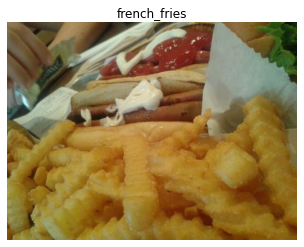

In [60]:
import random

random_num = random.randint(0,100)
img = view_random_image(target_dir='data/all_food_classes/train/',target_class=class_names[random_num])

## Callbacks

In [61]:
early_Stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

In [62]:
checkpoint_path = '101_classes_10_percent_data_model_checkpoint'
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path,
    save_weights_only = True,
    monitor = 'val_accuracy',
    save_best_only = True,
)

## Data Augmentation layer

In [63]:
from tensorflow.keras.layers.experimental import preprocessing

In [64]:
data_augmentation = tf.keras.Sequential([
    preprocessing.RandomFlip('horizontal'),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomWidth(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomZoom(0.2),
], name='augmentation_layer')

## Bulding Model

* **EfficientNetB0 Model** with no top layers

In [71]:
#Turning on mixed precision
from tensorflow.keras import mixed_precision

In [72]:
mixed_precision.set_global_policy('mixed_float16')

The dtype policy mixed_float16 may run slowly because this machine does not have a GPU. Only Nvidia GPUs with compute capability of at least 7.0 run quickly with mixed_float16.
If you will use compatible GPU(s) not attached to this host, e.g. by running a multi-worker model, you can ignore this warning. This message will only be logged once


In [73]:
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

inputs = layers.Input(shape=(224, 224, 3), name='input_layer')
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dense(101)(x)
outputs = layers.Activation('softmax', dtype=tf.float32, name='softmax_float32_layer')(x)

model_1 = tf.keras.Model(inputs, outputs)

In [74]:
model_1.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
augmentation_layer (Sequenti (None, None, None, 3)     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_pooling2d_3 ( (None, 1280)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 64)                81984     
_________________________________________________________________
dense_6 (Dense)              (None, 101)               6565      
_________________________________________________________________
softmax_float32_layer (Activ (None, 101)               0   

In [ ]:
model_1.compile(
    loss = 'categorical_crossentropy',
    optimizer = Adam(),
    metrics = ['accuracy'],
)

history_1 = model_1.fit(
    train_data,
    epochs = 10,
    steps_per_epoch = len(train_data),
    validation_data = test_data,
    validation_steps = int(0.15 * len(test_data)),
    callbacks = [
        early_Stopping,
        checkpoint_callback,
    ]
)

Epoch 1/10
   3/2368 [..............................] - ETA: 68:03:22 - loss: nan - accuracy: 0.0208    